In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import toml
import glob

# Read config and prepare dataset

In [2]:
config = toml.load('config.toml')

In [3]:
save_folder = config['preprocess']['output_folder']
music_data = ''
# print(isinstance(music_data, str))
for data_path in glob.glob(save_folder + '/*.npy'):
    read = np.load(data_path)
    if isinstance(music_data,str):
        music_data = read
    else:
        music_data = np.append(music_data, read, axis=1)

# music_data = np.concatenate(music_data, axis = 1)
print(music_data.shape)


(1025, 64705)


In [4]:
#normalize the input.
min = music_data.min()
max = music_data.max()
# normalize = lambda x : 1 / (1 + np.exp(x))
# normalize = lambda x : np.tanh(x)
# inverse_normalization = lambda x : np.arctanh(x)
# normalize = lambda x : (x-min) / (max-min)
# inverse_normalization = lambda x : x * (max-min) + min
music_data = np.abs(music_data)
# music_data = normalize(music_data)
music_data[0].mean()

0.94517434

In [47]:
music_data[0].max()

18.96064

In [6]:
# Data hyperparameters
seq_length = 32

# Learning hyperparameters
learning_rate = 0.005
batch_size = 20
input_size = music_data.shape[0]
ds_size = music_data.shape[1]

# Generation hyperparameters
temperature = 2.0
num_predictions = 120
# prediction_sample_size = 120


# Create the training dataset

In [7]:
music_ds = tf.data.Dataset.from_tensor_slices(music_data.T)
music_ds.element_spec

2022-01-26 18:31:04.065949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 18:31:04.116114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 18:31:04.116322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 18:31:04.117206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

TensorSpec(shape=(1025,), dtype=tf.float32, name=None)

In [8]:
def create_training_sequences(dataset: tf.data.Dataset, seq_length: int) -> tf.data.Dataset:
    """Create training sequences and respective labels for training."""
    seq_length += 1
    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                                drop_remainder=True)
    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)


    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        target = sequences[-1]
        return inputs, target

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)



In [9]:
seq_ds = create_training_sequences(music_ds, seq_length)
seq_ds.element_spec

(TensorSpec(shape=(32, 1025), dtype=tf.float32, name=None),
 TensorSpec(shape=(1025,), dtype=tf.float32, name=None))

In [10]:
buffer_size = ds_size - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            # .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            # .cache()
            # .prefetch(tf.data.experimental.AUTOTUNE)
            )



In [11]:
train_ds.element_spec

(TensorSpec(shape=(20, 32, 1025), dtype=tf.float32, name=None),
 TensorSpec(shape=(20, 1025), dtype=tf.float32, name=None))

# Create and train the model.

In [12]:

input_shape = (seq_length, input_size)
inputs = tf.keras.Input(input_shape)
x1 = tf.keras.layers.Dense(int(input_size * 0.25))(inputs)
x2 = tf.keras.layers.LSTM(int(input_size * 0.25))(x1)
# x2 = tf.keras.layers.LSTM(input_size)(inputs)
output = tf.keras.layers.Dense(input_size)(x2)
model = tf.keras.Model(inputs, output)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1025)]        0         
                                                                 
 dense (Dense)               (None, 32, 256)           262656    
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 1025)              263425    
                                                                 
Total params: 1,051,393
Trainable params: 1,051,393
Non-trainable params: 0
_________________________________________________________________


In [14]:
losses = model.evaluate(train_ds, return_dict=True)

     43/Unknown - 1s 2ms/step - loss: 0.7036

2022-01-26 18:31:16.249916: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


3233/3233 [==============================] - 8s 2ms/step - loss: 0.7096


In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]


In [16]:
%%time
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/10
3233/3233 [==============================] - 14s 4ms/step - loss: -126.5320
Epoch 2/10
3233/3233 [==============================] - 13s 4ms/step - loss: -557.9619
Epoch 3/10
3233/3233 [==============================] - 13s 4ms/step - loss: -1319.5439
Epoch 4/10
3233/3233 [==============================] - 13s 4ms/step - loss: -2263.5691
Epoch 5/10
3233/3233 [==============================] - 13s 4ms/step - loss: -3157.5327
Epoch 6/10
3233/3233 [==============================] - 13s 4ms/step - loss: -3484.6711
Epoch 7/10
3233/3233 [==============================] - 13s 4ms/step - loss: -4446.6504
Epoch 8/10
3233/3233 [==============================] - 13s 4ms/step - loss: -5416.2939
Epoch 9/10
3233/3233 [==============================] - 13s 4ms/step - loss: -6574.7178
Epoch 10/10
3233/3233 [==============================] - 13s 4ms/step - loss: -7442.7812
CPU times: user 4min 42s, sys: 19.5 s, total: 5min 2s
Wall time: 2min 10s


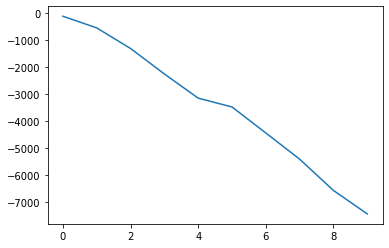

In [17]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [18]:
model.save('model')

2022-01-26 18:33:43.290859: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [19]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)
  predictions = model.predict(inputs)
  # predictions = inverse_normalization(predictions)
  return predictions


In [27]:
import random

note_start = random.randint(0, len(music_data.T)-seq_length-1)
sample = music_data.T[note_start:note_start+seq_length]

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

# S_dB = librosa.power_to_db(inverse_normalization(sample), ref=np.max)

# img = librosa.display.specshow(S_dB, x_axis='time',

#                          y_axis='mel', sr=22050,

#                          fmax=8000, ax=ax)

# fig.colorbar(img, ax=ax, format='%+2.0f dB')

# ax.set(title='Mel-frequency spectrogram')


In [31]:
generated_notes = []
for i in range(num_predictions):
    prediction = predict_next_note(sample, model, temperature)
    generated_notes.append(prediction)
    sample = np.delete(sample, 0, axis=0)
    sample = np.append(sample, prediction, axis=0)

generated_notes = np.concatenate(generated_notes)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

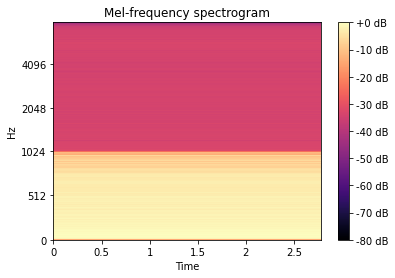

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

generated_notes = (generated_notes - generated_notes.min()) / (generated_notes.max()-generated_notes.min())

# print(generated_notes.min())
S_dB = librosa.power_to_db(generated_notes.T, ref=np.max)

img = librosa.display.specshow(S_dB, x_axis='time',

                         y_axis='mel', sr=22050,

                         fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')


In [45]:
import librosa.feature
if config['preprocess']['feature_extraction'] == 'mel':
    A = librosa.feature.inverse.mel_to_audio(np.log(generated_notes/(1-generated_notes)))
elif config['preprocess']['feature_extraction'] == 'mfcc':
    A = librosa.feature.inverse.mfcc_to_audio(generated_notes)
elif config['preprocess']['feature_extraction'] == 'stft':
    A = librosa.griffinlim(generated_notes)

In [46]:
import IPython.display as ipd
ipd.Audio(A, rate=22050)